# DON ETF prediction with ARIMA and SVR



The following is an example of univariate time series prediction based on close price of the Wisdom Tree U.S. Midcap Dividend Fund (Ticker symbol: DON) using an ARIMA model. The analysis of the timeseries is given in the DON time series analysis notebook. The first two cells involve importing, transforming, and making stationary the time series data, which is further explained in the time series analysis notebook.

Additionally, a support vector regression prediction and model is utilized based both on close price and the daily change in close price. Both models utilized an 80-20 train/test split, with the SVR model also testing on randomly sampled training data

The data modeled is from all historical data of the timeseries, as well as at 30, 60, 90, and 120 day intervals from an arbitrary start day in the timeseries 


In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import numpy as np
import os 
#getting data 

don_df = pd.read_csv('ETFS/don.us.csv')
lst_days = [30, 60, 90, 120]
start_day = 2000

def prep_df(df):
    df.columns = df.columns.str.lower()
    df.index = pd.to_datetime(df.date)
    return df

def get_start_date(df, start_day):
    day1 = datetime.datetime.strptime(df.date[0], '%Y-%m-%d')
    start_date = day1 + timedelta(days=start_day)
    return start_date

def get_end_date(initial_date, num_days):
    end_date = initial_date + timedelta(days=num_days)
    return end_date
        
don_all_days = prep_df(don_df)

start_date = get_start_date(don_all_days, start_day)

end_day = len(don_all_days)

end_dates_lst = [(get_end_date(start_date, i)) for i in lst_days]


def get_close_prices(start_day, end_day, df):
    return df.close.iloc[start_day: start_day + end_day ]
                         

def get_close_prices_multiple(start_day, days, df):
    df_dict = {}
    for i in days:
        df_dict[i] = get_close_prices(start_day, i, df)
    return df_dict

don_close_all = get_close_prices(0, end_day, don_all_days)

don_close_dict = get_close_prices_multiple(start_day, lst_days, don_all_days)

In [97]:
def log_transform(df):
    return np.log(df)
def difference(df):
    return (df- df.shift()).dropna()

def diff_and_log_transform(df):
    log_df = np.log(df)
    diff_log_df = (log_df - log_df.shift()).dropna()
    return diff_log_df

def diff_and_log_transform_multi(dict_in):
    df_dict = {}
    for i in dict_in:
        df_dict[i] = diff_and_log_transform(dict_in[i])  
    return df_dict

transformed_don_all_days_close = diff_and_log_transform(don_close_all)

transformed_dict_don = diff_and_log_transform_multi(don_close_dict)


In order to obtain the moving average (MA) parameters, an autocorrelation tests must be performed. The following cell provides both autocorrelation plots and a confidence test for the MA parameters based on the autocorrelation values

MA parameter all days
0
MA parameter 30 days
0
MA parameter 60 days
0
MA parameter 90 days
0
MA parameter 120 days
0


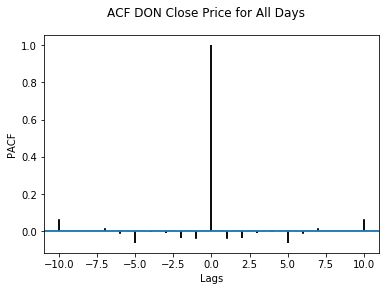

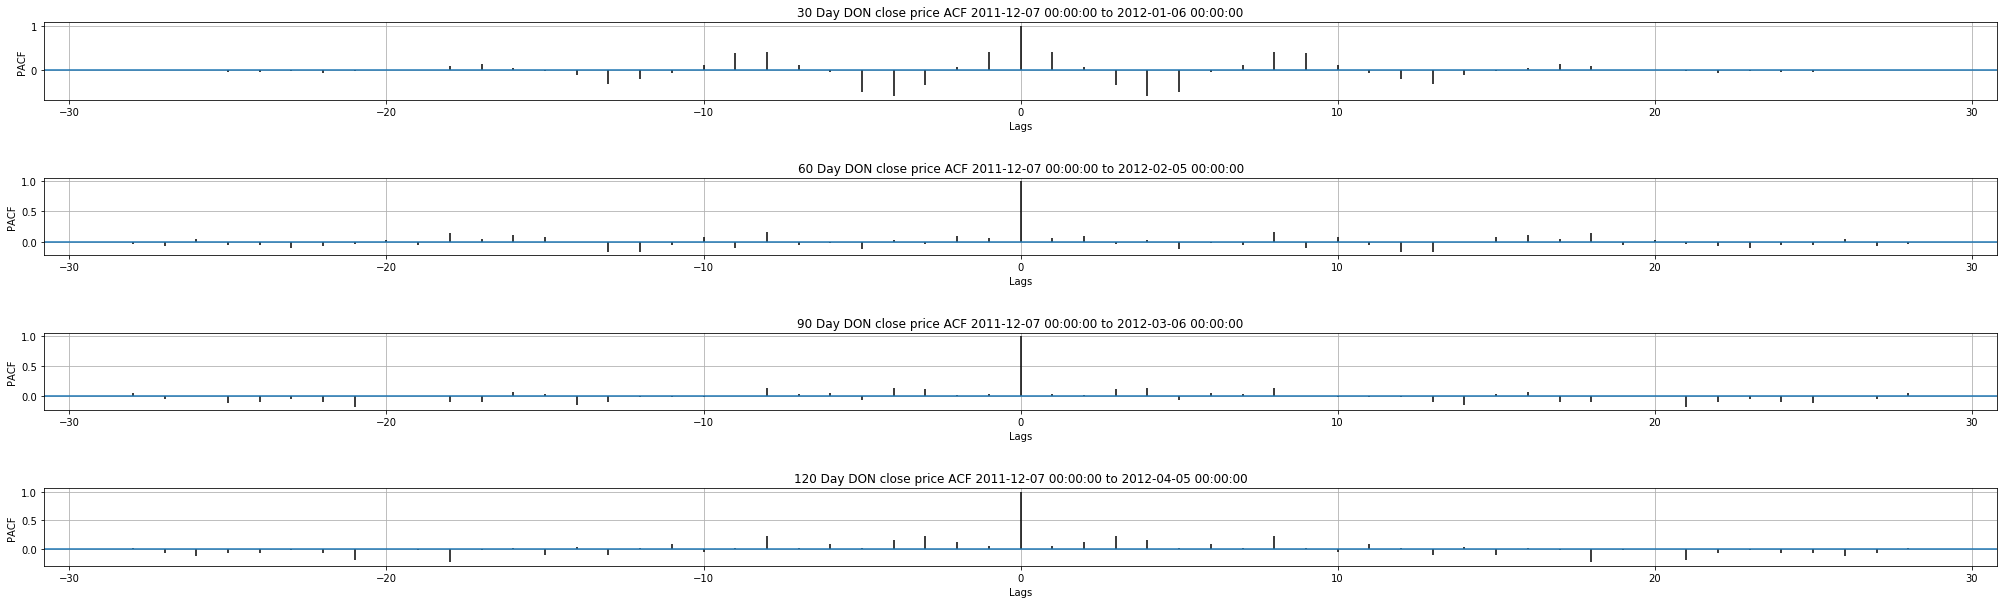

In [110]:
from statsmodels.tsa.stattools import acf

def acf_dict(dict_in):
    df_dict = {}
    for i in dict_in:
        df_dict[i] = acf(dict_in[i])
    return df_dict

acf_don_all_days = acf(transformed_don_all_days_close)

acf_dict_don = acf_dict(transformed_dict_don)

plt.acorr(acf_don_all_days)
plt.ylabel('ACF')
plt.xlabel('Lags')
plt.suptitle('ACF DON Close Price for All Days')


    

def find_ma_prm(df_acf):
    for i in range(0, len(df_acf)):
        if df_acf[i] <= 1.96/np.sqrt(len(df_acf) -1):
            return i -1
        
def find_ma_prm_dict(dict_in):
    df_dict = {}
    for i in dict_in:
        df_dict[i] = find_ma_prm(dict_in[i])
    return df_dict

ma_prm_don_all_days = find_ma_prm(acf_don_all_days)

ma_prm_dict_don = find_ma_prm_dict(acf_dict_don)

plt.acorr(pacf_don_all_days)
plt.ylabel('PACF')
plt.xlabel('Lags')
plt.suptitle('ACF DON Close Price for All Days')


print('MA parameter all days')
print(ma_prm_don_all_days)

fig, axes = plt.subplots(4, gridspec_kw={'hspace': 1, 'wspace': 1}, figsize=(35,10))
for ax in axes.flat:
    ax.set(xlabel='Lags', ylabel='PACF')
    
    
ax_num = 0 
for i in lst_days:
    axes[ax_num].acorr(acf_dict_don[i], usevlines=True, maxlags=28)
    axes[ax_num].grid(True)
    axes[ax_num].set_title(str(i) + ' Day DON close price ACF '+ str(start_date) + ' to ' + str(end_dates_lst[ax_num]))
    print('MA parameter ' + str(i) + ' days')
    print(ma_prm_dict_don[i])
    ax_num +=1 

In order to obtain the autoregression (AR) parameters, a partical autocorrelation tests must be performed. The following cell provides both partial autocorrelation plots and a confidence test for the AR parameters based on the partial autocorrelation values

AR parameter all days
0
AR parameter 30 days
0
AR parameter 60 days
0
AR parameter 90 days
0
AR parameter 120 days
0


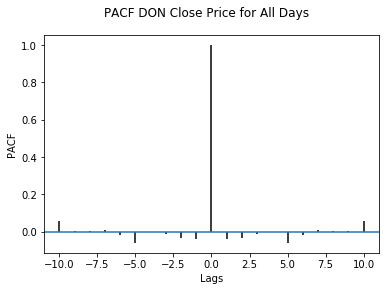

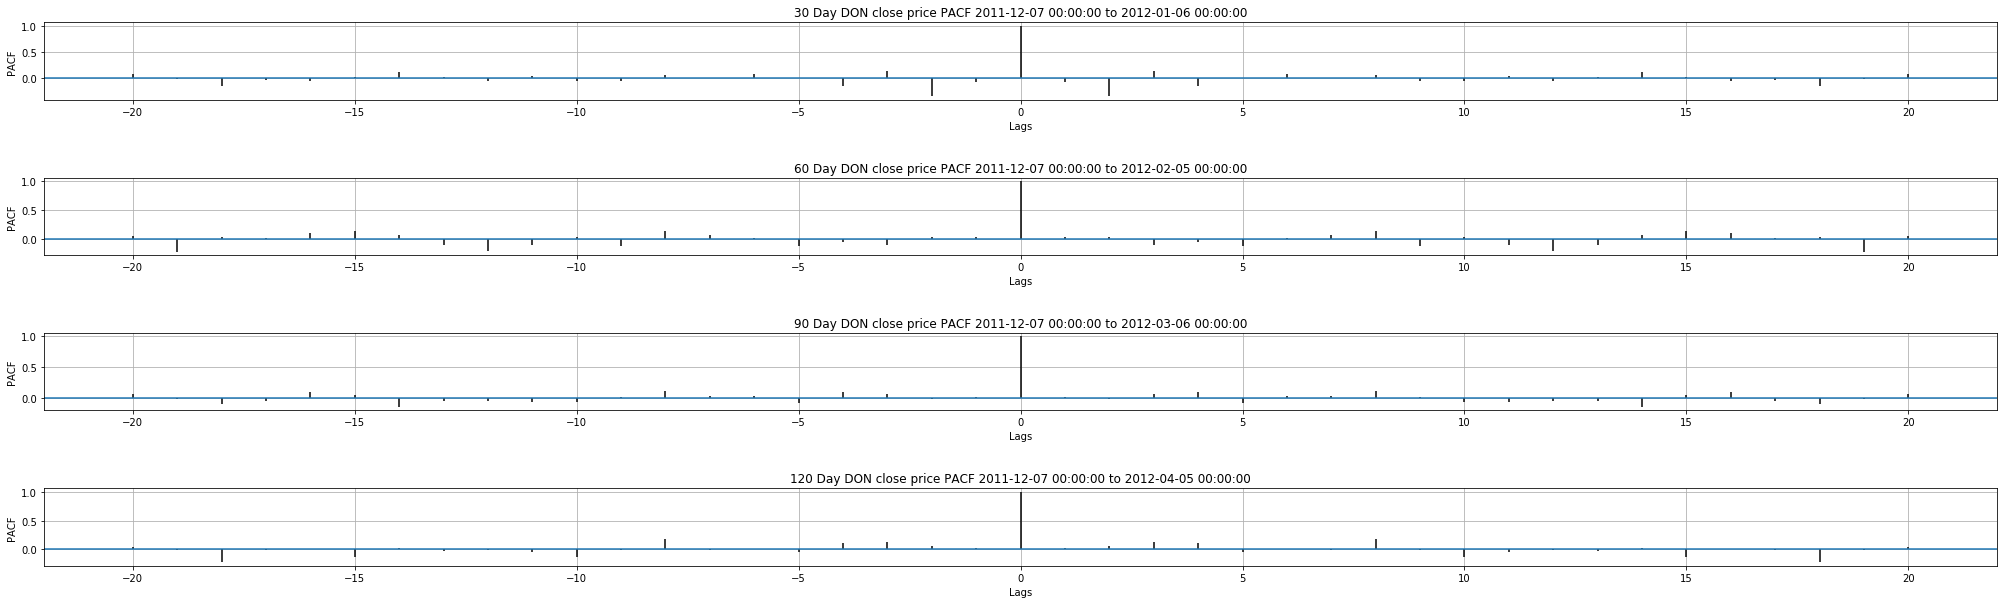

In [109]:
from statsmodels.tsa.stattools import pacf

def pacf_dict(dict_in):
    df_dict = {}
    for i in dict_in:
        df_dict[i] = pacf(dict_in[i], nlags = 20)
    return df_dict

pacf_all_don_days = pacf(transformed_don_all_days_close)

pacf_dict_don = pacf_dict(transformed_dict_don)

def find_ar_prm(df_pacf):
    for i in range(0, len(df_pacf)):
        if df_pacf[i] <= 1.96/np.sqrt(len(df_pacf) -1):
            return i -1 
        
def find_ar_prm_dict(dict_in):
    df_dict = {}
    for i in dict_in:
        df_dict[i] = find_ar_prm(dict_in[i])
    return df_dict
        
        
ar_prm_don_all_days = find_ar_prm(pacf_all_don_days)

ar_prm_dict_don = find_ar_prm_dict(pacf_dict_don)


plt.acorr(pacf_don_all_days)
plt.ylabel('PACF')
plt.xlabel('Lags')
plt.suptitle('PACF DON Close Price for All Days')


print('AR parameter all days')
print(ar_prm_don_all_days)

fig, axes = plt.subplots(4, gridspec_kw={'hspace': 1, 'wspace': 1}, figsize=(35,10))
for ax in axes.flat:
    ax.set(xlabel='Lags', ylabel='PACF')
    
    
ax_num = 0 
for i in lst_days:
    axes[ax_num].acorr(pacf_dict_don[i], usevlines=True, maxlags=20)
    axes[ax_num].grid(True)
    axes[ax_num].set_title(str(i) + ' Day DON close price PACF '+ str(start_date) + ' to ' + str(end_dates_lst[ax_num]))
    print('AR parameter ' + str(i) + ' days')
    print(ar_prm_dict_don[i])
    ax_num +=1 


This cell contains the code for the ARIMA model, imported from the statsmodels package. The arima function uses about 80% to train on and then a test on the remaining 20% of the data is utilized to test on. Additionally, MSE error is included in order to gauge the accuracy of the model. The first model created is that of all historical DON data, followed by those of the 30, 60, 90, 120 day increments

DON all days MSE: 7.197337862273202


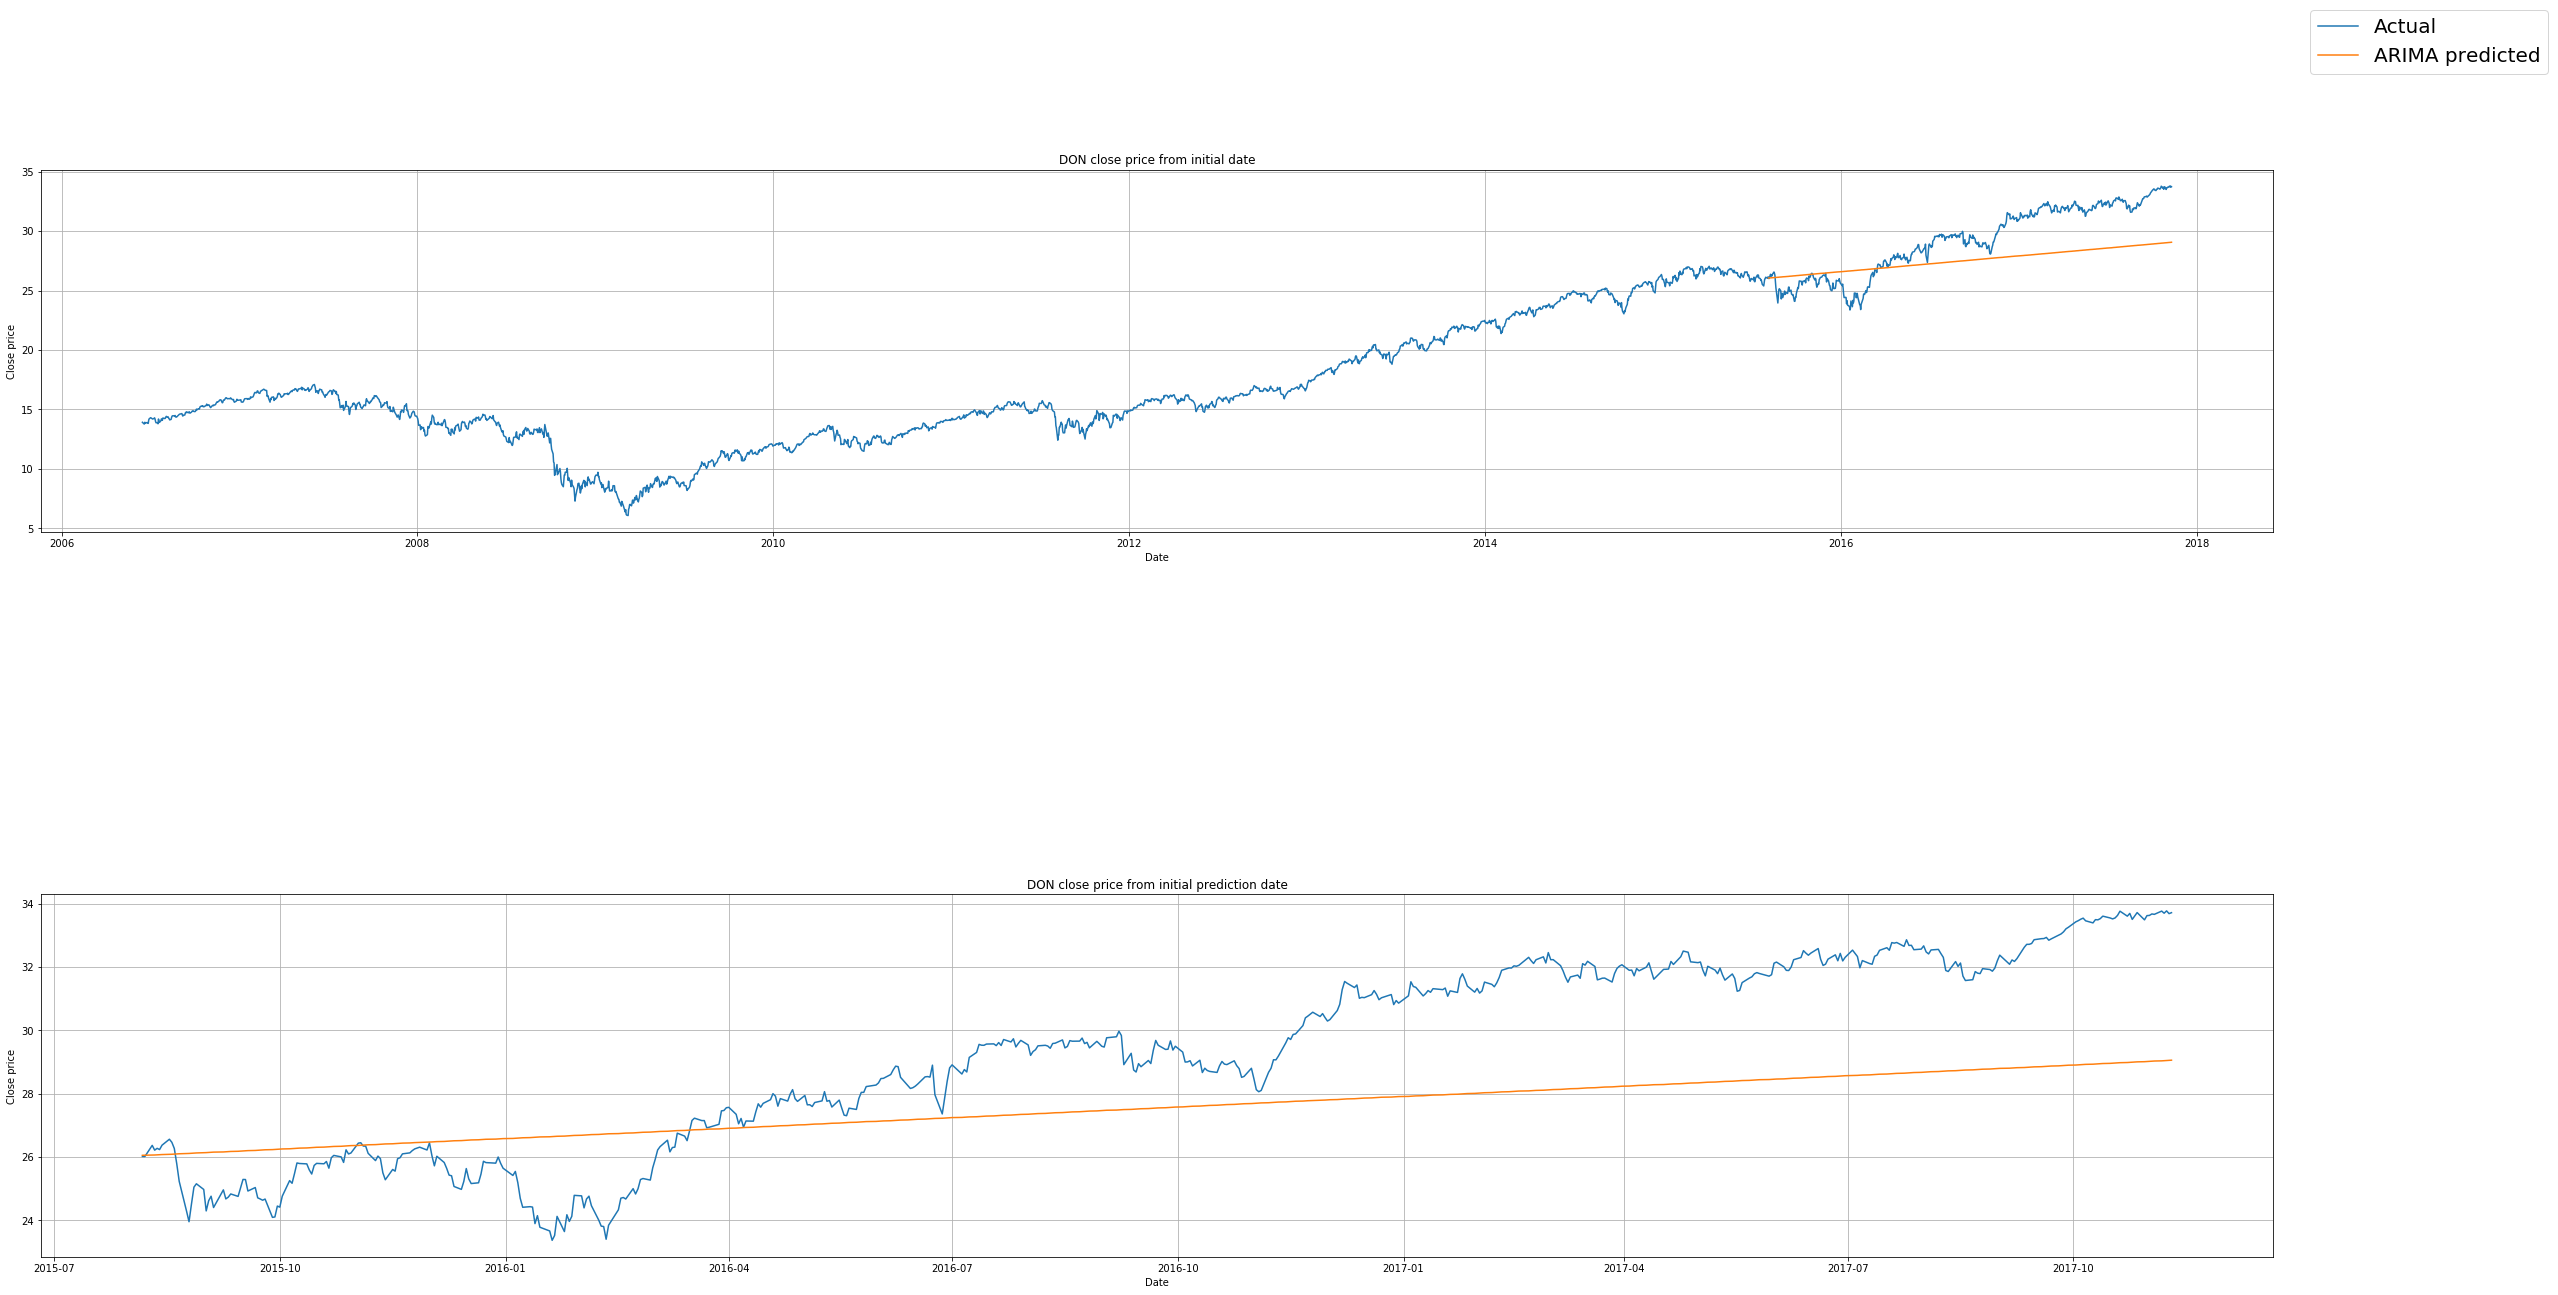

In [103]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


def arima_model(df, p, d, q):
    test_index = math.ceil(.8 * len(df))
    train, test = df.iloc[:test_index], df.iloc[test_index+1:]
    num_steps = len(test)
    model = ARIMA(train, order=(q,d,p))
    model_fit = model.fit(disp=0, transparams= False)
    predicted_vals = model_fit.forecast(steps = num_steps)[0].flatten()
    mse = mean_squared_error(test, predicted_vals)
    df_predicted = pd.DataFrame(predicted_vals, index= df.index[test_index+1:])
    model_dict = {'df_predicted': df_predicted, 'mse': mse, 'model_fit': model_fit, 'model': model, 'orig_df_pred_date': test}
    return model_dict
    
don_all_prediction_start = math.ceil(.8 * len(don_close_all))
    
don_close_arima = arima_model(don_close_all, ar_prm_don_all_days, 1, ma_prm_don_all_days)

don_predicted_all_df = don_close_arima['df_predicted']

fig, axes = plt.subplots(2, gridspec_kw={'hspace': 1, 'wspace': 1}, figsize=(40,20))
for ax in axes.flat:
    ax.set(xlabel='Date', ylabel='Close price')


line_labels = ['Actual', 'ARIMA predicted']
l1 = axes[0].plot(don_close_all)
l2 = axes[0].plot(don_predicted_all_df)
axes[0].grid(True)
axes[0].set_title('DON close price from initial date')
fig.legend([l1, l2],     # The line objects
           labels=line_labels,   # The labels for each line
           loc="center top",   # Position of legend  # Title for the legend
           prop={'size': 20}
           )

axes[1].plot(don_close_arima['orig_df_pred_date'])
axes[1].plot(don_predicted_all_df)
axes[1].grid(True)
axes[1].set_title('DON close price from initial prediction date')
    
print('DON all days MSE: ' + str(don_close_arima['mse']))


DON 30 days MSE: 0.07041004311430976
DON 60 days MSE: 0.3797766108089177
DON 90 days MSE: 0.6293578884089365
DON 120 days MSE: 3.186780108526577


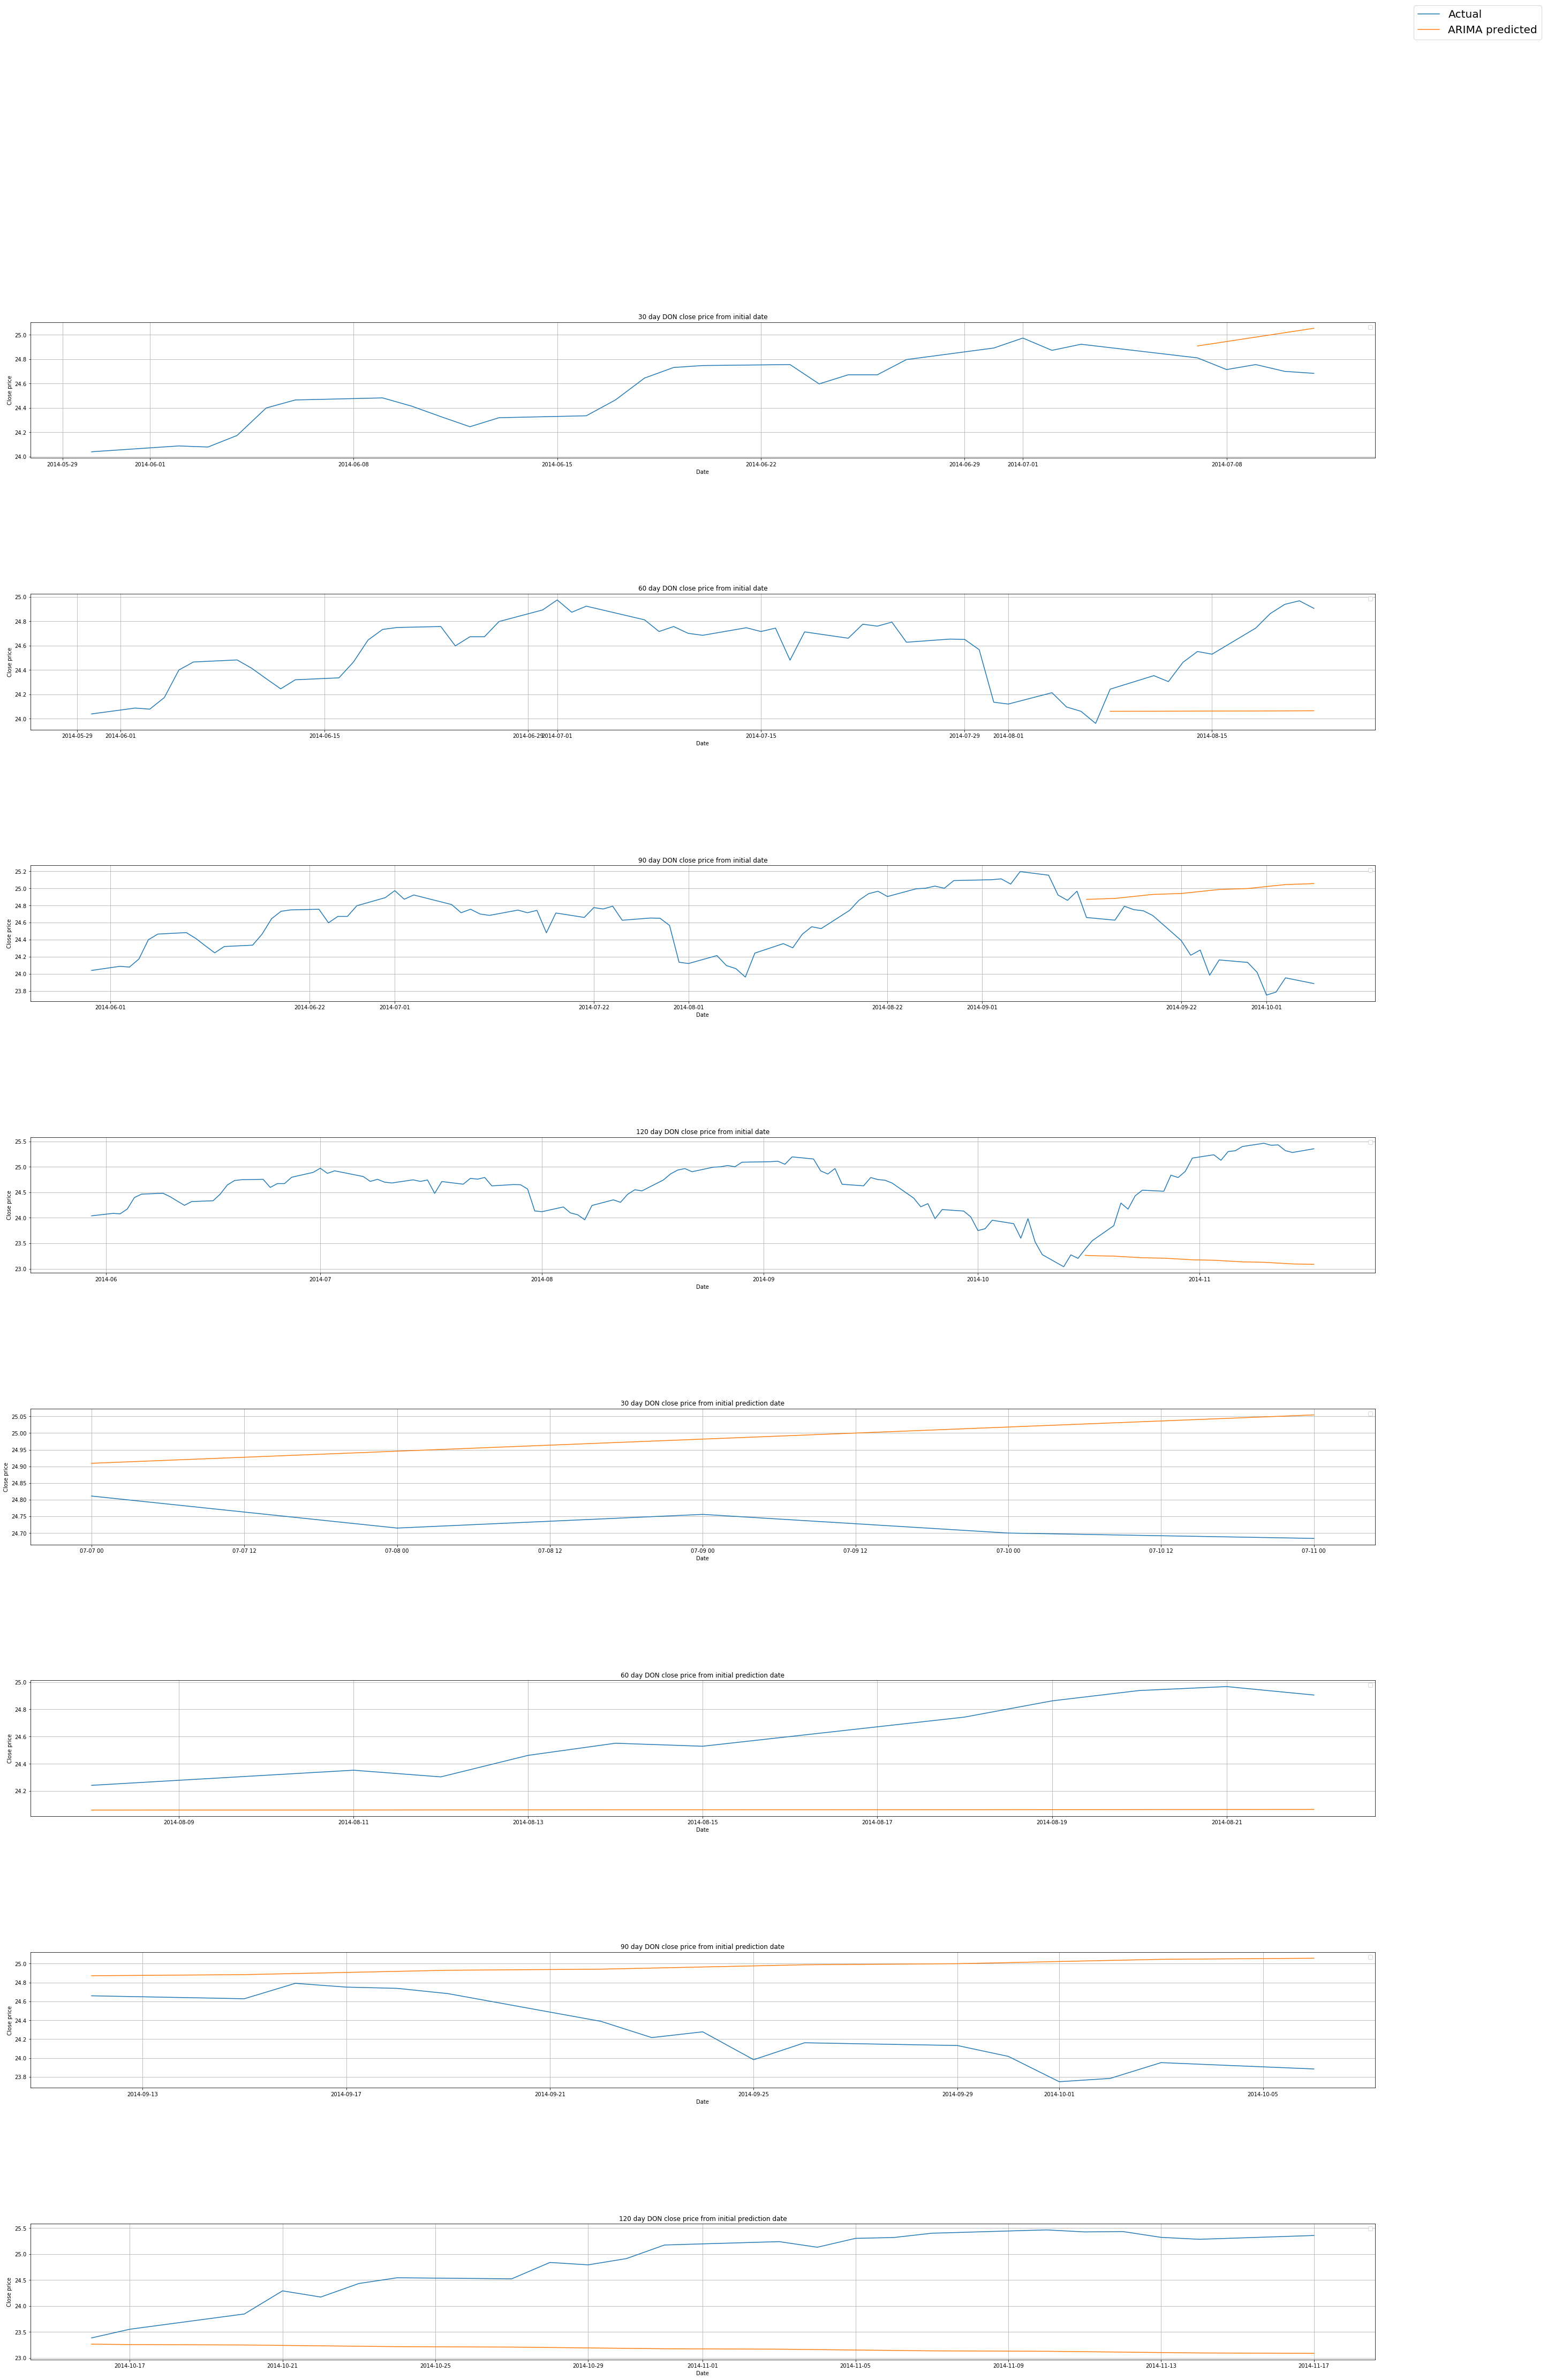

In [111]:
d_prm_don_dict = {30 : 1, 60: 1, 90: 1, 120: 1}

   
def arima_model_dict(dict_df, ar_dict, d_dict, ma_dict):
    results_dict = {}
    for i in dict_df:
        results_dict[i] = arima_model(dict_df[i], ar_dict[i], d_dict[i], ma_dict[i])
    return results_dict
    
don_close_arima_dict = arima_model_dict(don_close_dict, ar_prm_dict_don, d_prm_don_dict, ma_prm_dict_don)


    
pred_start_dict = {}
fig, axes = plt.subplots(8, gridspec_kw={'hspace': 1, 'wspace': 1}, figsize=(45,70))
for ax in axes.flat:
    ax.set(xlabel='Date', ylabel='Close price')

ax_num = 0 
for i in lst_days:
    l1 = axes[ax_num].plot(don_close_dict[i])
    l2 = axes[ax_num].plot(don_close_arima_dict[i]['df_predicted'])
    axes[ax_num].set_title(str(i) + ' day '+ 'DON close price from initial date')
    axes[ax_num].legend('Actual', 'ARIMA Predicted')
    axes[ax_num].grid(True)
    ax_num +=1
    
ax_num = 4
for i in lst_days:
    l3 = axes[ax_num].plot(don_close_arima_dict[i]['orig_df_pred_date'])
    l4 = axes[ax_num].plot(don_close_arima_dict[i]['df_predicted'])
    axes[ax_num].grid(True)
    axes[ax_num].set_title(str(i) + ' day '+ 'DON close price from initial prediction date')
    axes[ax_num].legend('Actual', 'ARIMA Predicted')
    ax_num +=1
    
    
fig.legend([l1, l2],
           labels=line_labels, 
           loc="center top",  
           prop={'size': 20}
           )
for i in don_close_arima_dict:
    print('DON ' + str(i) + ' days MSE: ' + str(don_close_arima_dict[i]['mse']))
              
              

The below cell contains the code for the SVR model. The SVR is applied to the close price data for each day and the change in close price from the previous day. The SVR model utilizes randomly sampled training data to which is scored by R^2 in addition to a train test split. The cell below shows the full historical data prediction and it's corresponding training and test R^2 values and MSE. The cell following contains the same information for the 30, 60, 90, and 120 day intervals. 

all days days r^2 train: 0.9941457865020238 r^2 test: 0.9941452680842615 mse: 0.0005074778514133733


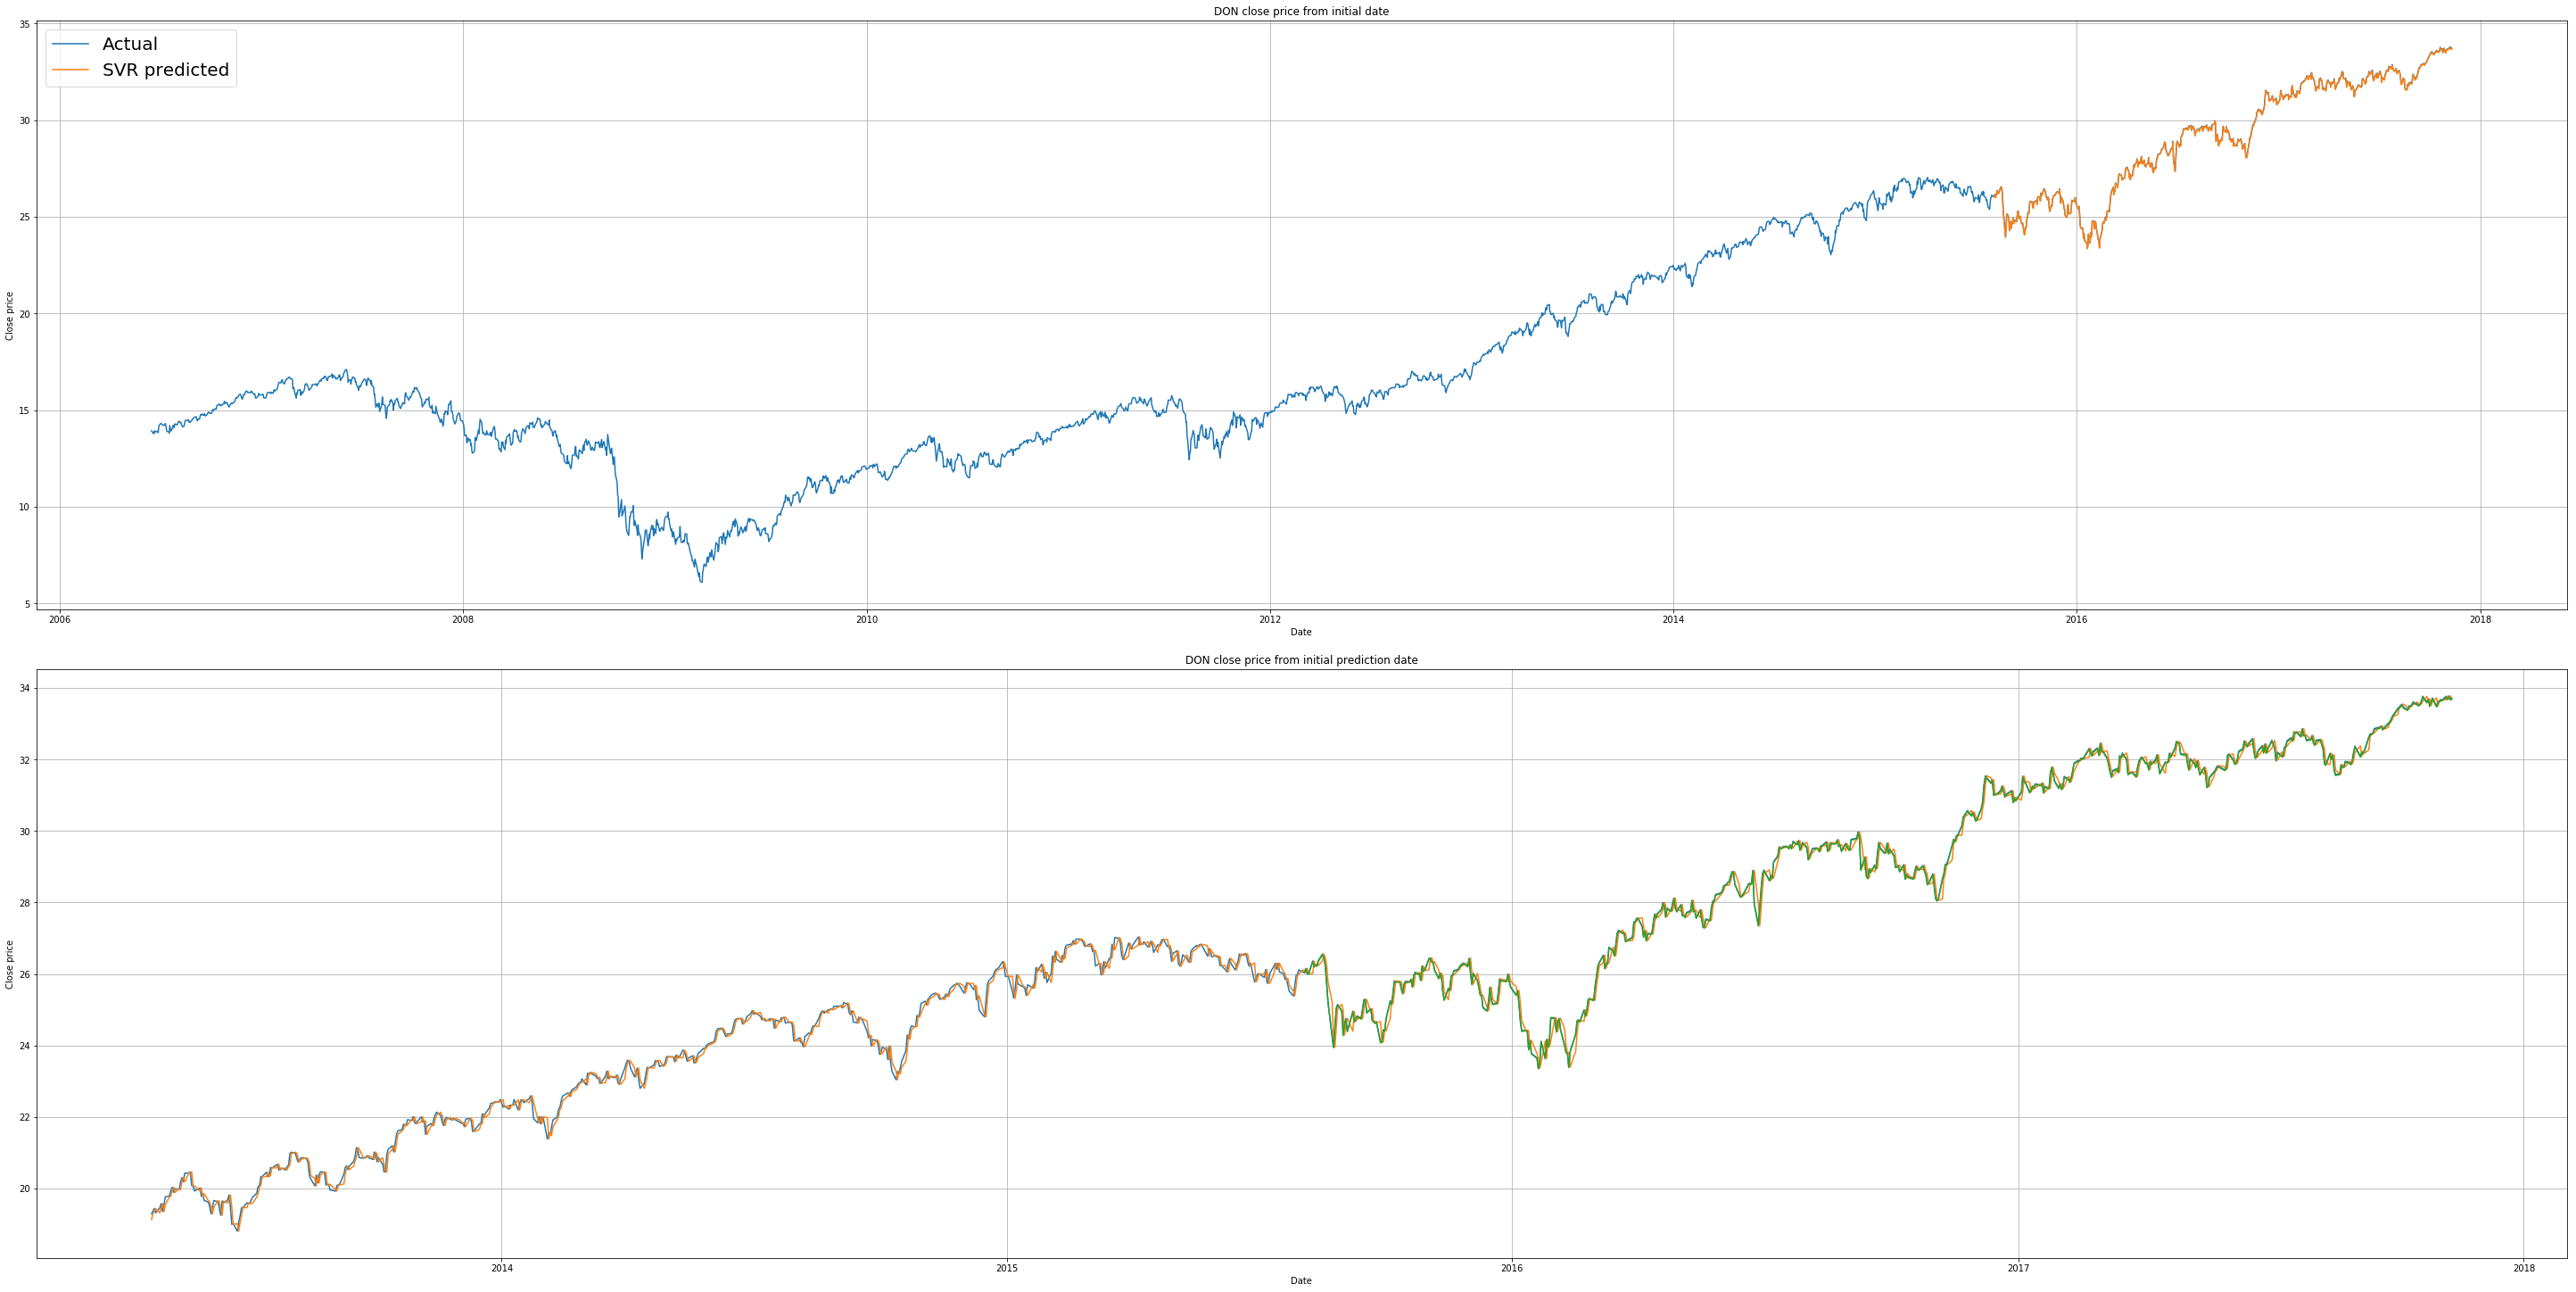

In [112]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

def create_df_close_change(df, change_days):
    data = df.values
    df_new = pd.DataFrame(data, df.index, columns = ['close'])
    df_new['change'] = df_new['close'].shift(change_days)
    return df_new.fillna(0)
    

don_all_price_change = create_df_close_change(don_close_all, 1)
def svr_predict(df):
    X_train, X_test, y_train, y_test = train_test_split(df['close'], df['change'], test_size=.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True)
    orig_df_predict_date = df[len(X_train):]
    model = SVR(kernel = 'linear')
    model_fit = model.fit(X_train.ravel().reshape(-1,1), y_train)
    predicted_vals = model_fit.predict(X_test.ravel().reshape(-1,1))
    r2_train = model_fit.score(X_train.ravel().reshape(-1,1), y_train)
    r2_test = model_fit.score(X_test.ravel().reshape(-1,1), y_test)
    mse = mean_squared_error(X_test, predicted_vals)
    df_predicted = pd.DataFrame(predicted_vals, index= y_test.index, columns = ['predicted price'])
    model_dict = {'model_fit': model_fit, 'model': model, 'df_predicted': df_predicted, 'r2_train': r2_train, 'r2_test': r2_test,'df_predicted': df_predicted, 'mse': mse, 
                  'orig_df_pred_date': orig_df_predict_date}
    return model_dict

don_all_svr = svr_predict(don_all_price_change)

fig, axes = plt.subplots(2, gridspec_kw={'hspace': 1, 'wspace': 1}, figsize=(40,20), constrained_layout=True)
for ax in axes.flat:
    ax.set(xlabel='Date', ylabel='Close price')


    
line_labels = ["Actual", "SVR predicted"]
l1 = axes[0].plot(don_close_all)
l2 = axes[0].plot(don_all_svr['df_predicted'])
axes[0].grid(True)
axes[0].set_title('DON close price from initial date')

axes[0].legend([l1, l2],     # The line objects
           labels=line_labels,
            loc = "center top",
            prop={'size': 20})

axes[1].plot(don_all_svr['orig_df_pred_date'])
axes[1].plot(don_all_svr['df_predicted'])
axes[1].grid(True)
axes[1].set_title('DON close price from initial prediction date')



print('all days days' + ' r^2 train: '  + str(don_all_svr['r2_train']) + ' r^2 test: ' + str(don_all_svr['r2_test']) + ' mse: ' + str(don_all_svr['mse']))

30 day r^2 train: -0.02175994615127186 r^2 test: -2.3191062912491156 mse: 0.011282673078690521
60 day r^2 train: 0.7238589090881913 r^2 test: 0.8251557479531735 mse: 0.0010685496195943643
90 day r^2 train: 0.036765777737698846 r^2 test: 0.802775459077106 mse: 0.0004766783651250088
120 day r^2 train: 0.03720467902092306 r^2 test: 0.9295688433747191 mse: 0.0059399665175184175


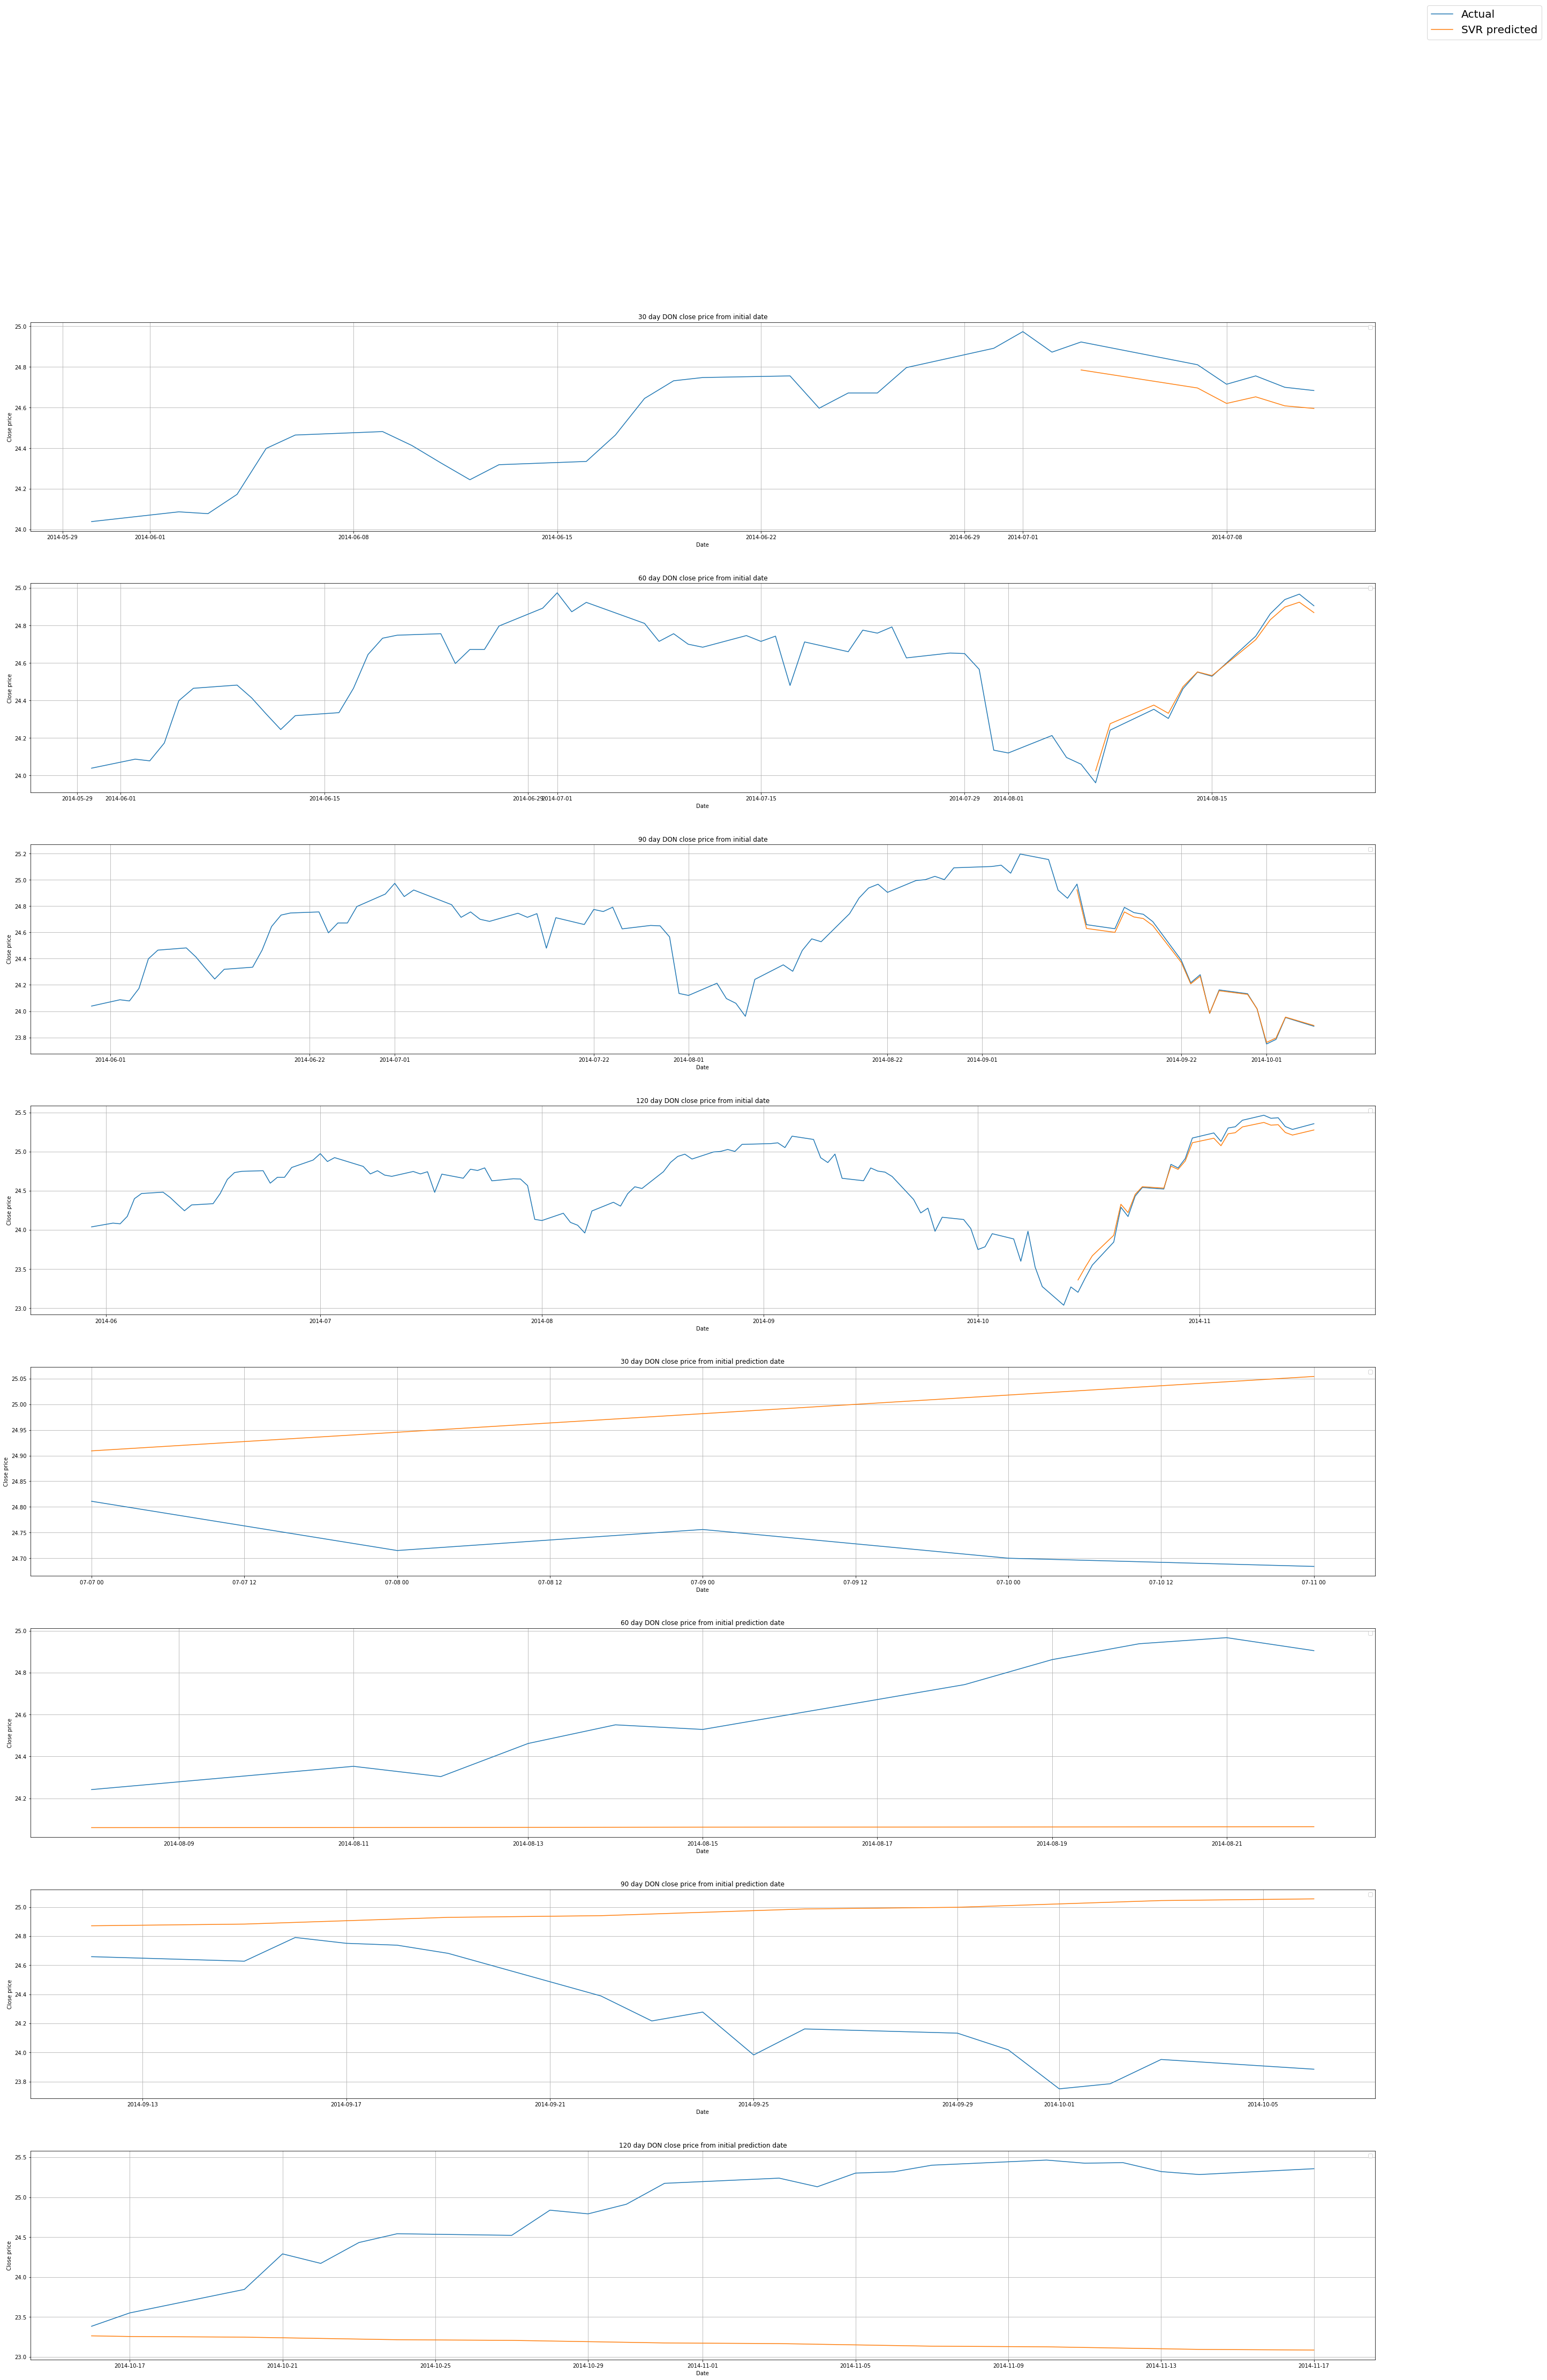

In [116]:
def create_df_close_change_dict(df_dict, change_days):
    new_dict = {}
    for i in df_dict:
        new_dict[i] = create_df_close_change(df_dict[i], change_days)
    return new_dict
        

def svr_predict_dict(df_dict):
    new_dict = {}
    for i in df_dict:
        new_dict[i] = svr_predict(df_dict[i])
    return new_dict

close_change_dict = create_df_close_change_dict(don_close_dict, 1)

svr_dict = svr_predict_dict(close_change_dict)

fig, axes = plt.subplots(8, gridspec_kw={'hspace': 0.25, 'wspace': 1}, figsize=(45,70))
for ax in axes.flat:
    ax.set(xlabel='Date', ylabel='Close price')

ax_num = 0 
for i in lst_days:
    l1 = axes[ax_num].plot(don_close_dict[i])
    l2 = axes[ax_num].plot(svr_dict[i]['df_predicted'])
    axes[ax_num].set_title(str(i) + ' day '+ 'DON close price from initial date')
    axes[ax_num].legend('Actual', 'SVR Predicted')
    axes[ax_num].grid(True)
    ax_num +=1
    
ax_num = 4
for i in lst_days:
    axes[ax_num].plot(don_close_arima_dict[i]['orig_df_pred_date'])
    axes[ax_num].plot(don_close_arima_dict[i]['df_predicted'])
    axes[ax_num].grid(True)
    axes[ax_num].set_title(str(i) + ' day '+ 'DON close price from initial prediction date')
    axes[ax_num].legend('Actual', 'SVR Predicted')
    ax_num +=1

fig.legend([l1, l2], labels=line_labels, loc= 'center top', prop={'size': 20})


for i in svr_dict:
    print(str(i) + ' day' ' r^2 train: ' + str(svr_dict[i]['r2_train']) + ' r^2 test: ' + str(svr_dict[i]['r2_test']) + ' mse: ' + str(svr_dict[i]['mse']))

## Analysis

# Entire historical DON data

The ARIMA model seems to provide reasonable predictions. The ARIMA model's mean squared error of ~7 may be fairly reasonable given the longevity of the time series, and, as MSE gives more weight larger errors, it seems that this may be a reasonable estimation. Thus, overfitting may not be a problem for this model. 
The SVR model, on the other hand, despite providing strong test and train (taken from the randomly sampled training data) r^2 values, has a very low MSE and the respective r^2 values are highly similar. This seems to show a strong model, although the low MSE may imply overfitting. 

# Shorter DON forecasts

The 30 day ARIMA model provides a low MSE, while the MSE monotonically increases for the longer timespans. The 30 day ARIMA model may be prone to overfitting, and this is likely because of the samller sample size. Both the 60 and 90 day models seem to give fairly reasonable MSE values. The 120 day model has the highest MSE value, which may imply an underfitting of the model. 
The SVR model for the 30 day interval however, has r^2 values outside of the correct range and a very low MSE. This model is therefore not accurate and additionally from the MSE likely overfits. The fact the r^2 values are outside of the appropriate range suggests that the data size is too small. The higher intervals show improved test r^2 values, but weak train r^2 values, with 60 day performing the best. These seem to improve for the 60 day model, but decrease afterward, especially in the r^2 test values. 

It appears ARIMA models may be more suited for short term predictions, whereas SVR predictions may prove stronger for long term predictions. 